# 计算机视觉解释

`vision.interpret`是通过继承它来为不同的视觉任务实现自定义解释类的模块。

---

## class SegmentationInterpretation
`SegmentationInterpretation(learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=<DatasetType.Valid: 2>) :: Interpretation`

分割模型的解释方法。

**top_losses**

`top_losses(sizes:Tuple, k:int=None, largest=True)`

减少压平损失，为每个图像提供单一损失值

**_interp_show**

`_interp_show(ims:ImageSegment, classes:Collection[T_co]=None, sz:int=20, cmap='tab20', title_suffix:str=None)`

显示带有颜色映射标签的ImageSegment

**show_xyz**

`show_xyz(i, classes:list=None, sz=10)`

来自带有颜色映射的self.ds的show（image，true和pred），可选择只有绘图

**_generate_confusion**

`_generate_confusion()`

平均和每图像混淆：给定真实标签的像素的交集，真实标签总和为1

**_plot_intersect_cm**

`_plot_intersect_cm(cm, title='Intersection with Predict given True')`

绘制混淆矩阵：_generate_confusion生成的self.mean_cm或self.single_img_cm

让我们展示一旦我们训练分割模型，如何使用SegmentationInterpretation。

## 训练

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

In [2]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

In [3]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str)
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [4]:
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=16, path=camvid)
        .normalize(imagenet_stats))

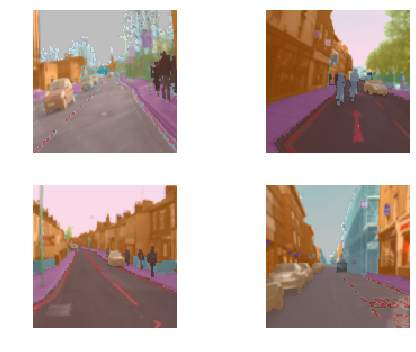

In [5]:
data.show_batch(rows=2, figsize=(7,5))

In [6]:
learn = unet_learner(data, models.resnet18)
learn.fit_one_cycle(3,1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,time
0,23.826647,2.149267,01:15
1,12.656721,2.594177,01:00
2,8.893617,2.407589,01:00


警告：对于这个表现不佳的模型，以下结果将没有多大意义，但功能将很容易解释

## 解释

In [7]:
interp = SegmentationInterpretation.from_learner(learn)

NameError: name 'SegmentationInterpretation' is not defined

In [9]:
??SegmentationInterpretation

Object `SegmentationInterpretation` not found.


由于使用了CrossEntropyLoss()的FlattenedLoss，我们重新整形然后采用每个图像的像素损失的平均值。 为了做到这一点，我们需要传递`sizes:tuple`到top_losses()

In [ ]:
top_losses, top_idxs = interp.top_losses(sizes=(128,128))

接下来，我们可以生成类似于我们通常用于分类的混淆矩阵。 生成两个混淆矩阵：mean_cm表示全局标签性能，single_img_cm表示相同但对于数据集中的每个单独图像。

矩阵中的值计算如下：
\begin{align} \ CM_{ij} & = IOU(Predicted , True | True) \\ \end{align}

或者用简单的英语：给定真实像素的预测标签的像素比率